In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import cv2
import glob
import h5py
from skimage.morphology import disk
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
# for plot figures
plt.rcParams['svg.fonttype'] = 'none'
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])

In [4]:
#import data
movie_name = "../data/image_twilight_bgr.h5"

#read movie real data, real means: after spectral calibration, before gamma correction for the screen
def read_sunriseset_from_h5(filename):
    h5f = h5py.File(filename,'r')
    img_sunrises=h5f['sunrises_bgr_real'][:]
    img_sunsets=h5f['sunsets_bgr_real'][:]
    h5f.close()
    return img_sunrises,img_sunsets
img_sunrises,img_sunsets=read_sunriseset_from_h5(movie_name)
print (img_sunrises.shape)
print (img_sunsets.shape)

(6, 437, 437, 3)
(8, 437, 437, 3)


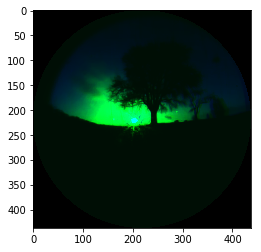

In [5]:
#show one example, image real value
plt.imshow(img_sunrises[5][...,::-1])

In [6]:
#to better visulaize image, use gamma correction to transfer image real to image view
def img_real2view(img):
    gamma_correction=lambda x:np.power(x,1.0/2.2)
    img_shape=img.shape
    # gray image
    if np.size(img_shape)==2:
        #uint8
        if np.max(img)>1:
            temp_view=np.zeros_like(img,dtype=np.float32)
            temp_view=np.float32(img)/255.0#float32, 1.0
            temp_view=gamma_correction(temp_view)
            temp_view2=np.zeros_like(img,dtype=np.uint8)
            temp_view2=np.uint8(temp_view*255)
            return temp_view2
        #float
        if np.max(img)<2:
            return gamma_correction(img)
    #color image
    if np.size(img_shape)==3:
        #uint8
        if np.max(img)>1:
            temp_view=np.zeros_like(img,dtype=np.float32)
            temp_view=np.float32(img)/255.0#1.0
            temp_view=gamma_correction(temp_view)
            temp_view2=np.zeros_like(img,dtype=np.uint8)
            temp_view2=np.uint8(temp_view*255)#255
            return temp_view2
        #float
        if np.max(img)<2:
            return gamma_correction(img)


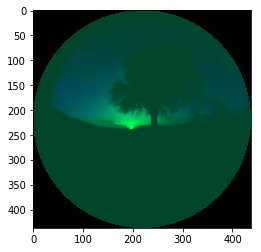

In [7]:
#show one example, image view value
plt.imshow(img_real2view(img_sunrises[1])[...,::-1])

### Functions

In [8]:
#function: gaussian kernel 1d
#input: sigma: std
#       order: A positive order corresponds to convolution with
#              that derivative of a Gaussian, use 0 here
#       radius: radius of the filter
def my_gaussian_kernel1d(sigma, order, radius):
    """
    Computes a 1D Gaussian convolution kernel.
    """
    if order < 0:
        raise ValueError('order must be non-negative')
    p = np.polynomial.Polynomial([0, 0, -0.5 / (sigma * sigma)])
    x = np.arange(-radius, radius + 1)
    phi_x = np.exp(p(x), dtype=np.double)
    phi_x /= phi_x.sum()
    if order > 0:
        q = np.polynomial.Polynomial([1])
        p_deriv = p.deriv()
        for _ in range(order):
            # f(x) = q(x) * phi(x) = q(x) * exp(p(x))
            # f'(x) = (q'(x) + q(x) * p'(x)) * phi(x)
            q = q.deriv() + q * p_deriv
        phi_x *= q(x)
    return phi_x

#function: gaussian filter 2d
def my_gaussian_kernel2d(sigma,order,radius):
    g_ker_1d=my_gaussian_kernel1d(sigma, order, radius)
    g_ker_2d=np.outer(g_ker_1d, g_ker_1d)
    g_ker_2d /=g_ker_2d.sum()
    return g_ker_2d

#function: my difference of gaussian kernel 1d
#input: centersigma is the center sigma, surround sigma=1.5*centersigma, centersigma=RFradius
#       radius: defalt 3*centersigma 
#output: kernel size length: 1+3*centersigma*2
def my_DOG_kernel1d(centersigma,order,radius):
    surroundsigma=1.5*centersigma
    center_kernel1d=my_gaussian_kernel1d(centersigma,order,radius)
    surround_kernel1d=my_gaussian_kernel1d(surroundsigma,order,radius)
    out_kernel1d=center_kernel1d-surround_kernel1d
    return out_kernel1d

#function: my difference of gaussian kernel 2d, mimic retina center-surround onoff
#input: centersigma is the center sigma, surround sigma=1.5*centersigma
#       radius: kernelradius, defalt 3*centersigma 
#output: kernel size length: 1+3*centersigma*2
def my_DOG_kernel2d(centersigma,order,radius):
    surroundsigma=1.5*centersigma
    center_kernel2d=my_gaussian_kernel2d(centersigma,order,radius)
    surround_kernel2d=my_gaussian_kernel2d(surroundsigma,order,radius)
    out_kernel2d=center_kernel2d-surround_kernel2d
    return out_kernel2d

#function, calculate ONOFF for single pixel
#input:
#img: gray image, float, 1.0 (when phase srambled image, may be a little larger than 1.0)
#(xx,yy): center coordinate, xx: along height, yy: along width, RFradius: radius of center
#output:
#onoff value
def ONOFF_single(img,xx,yy,centersigma):
    surroundsigma=np.round(1.5*centersigma)
    kernelradius=3*centersigma
    temp=img[xx-kernelradius:xx+kernelradius+1,yy-kernelradius:yy+kernelradius+1]
    center_kernel2d=my_gaussian_kernel2d(centersigma,0,kernelradius)
    surround_kernel2d=my_gaussian_kernel2d(surroundsigma,0,kernelradius)
    centermean=np.sum(temp*center_kernel2d)
    surroundmean=np.sum(temp*surround_kernel2d)
    onoff=(centermean-surroundmean)/(centermean+surroundmean+1e-8)
    return onoff

#input: 
#centersigma is the center sigma
#img: image or image region, float
#output: onoff_img, float, -1.0 to 1.0
def onoff_wholeimg(img,centersigma):
    kernelradius=3*centersigma
    onoff_img=np.zeros((img.shape[0],img.shape[1]))
    for ii in np.arange(kernelradius,img.shape[0]-kernelradius-1):
        for jj in np.arange(kernelradius,img.shape[1]-kernelradius-1):
            onoff_img[ii,jj]=ONOFF_single(img,ii,jj,centersigma)
    if img.shape[0]==437:
        mask_con=np.zeros((437,437),np.uint8)
        cv2.circle(mask_con,(218,218),radius=218-kernelradius,color=255,thickness=-1)
        mask_con=np.float32(mask_con/255.0)
        onoff_img=np.multiply(onoff_img,mask_con)
    return onoff_img

#input: onoff_seed: random seed for contrast calculation
#onoff_num: random pick numbers
#centersigma is the center sigma
#img: image or image region, float 1.0 (when phase srambled, may be a little larger than 1.0)
#output: the onoff value distribution
def onoff_random(onoff_seed,onoff_num,centersigma,img):
    kernelradius=3*centersigma
    np.random.seed(onoff_seed+866)
    walk_height=np.random.choice(np.arange(kernelradius,img.shape[0]-kernelradius-1),onoff_num,replace=False)
    np.random.seed(onoff_seed+899)
    walk_width=np.random.choice(np.arange(kernelradius,img.shape[1]-kernelradius-1),onoff_num,replace=False)
    onoffs=np.zeros(onoff_num)
    for ii in range(onoff_num):
        onoffs[ii]=ONOFF_single(img,walk_height[ii],walk_width[ii],centersigma)
    return onoffs

#input: onoff_seed: random seed for contrast calculation
#onoff_num: total random pick numbers=numberofimages* each_random_pick_numbers
#centersigma is the center sigma
#imgs: images, all gray images, float 1.0 (when phase srambled, may be a little larger than 1.0)
#      format like: numberofimages*height*width
#output: the onoff value distribution
def onoff_random_imgs(onoff_seed,onoff_num,centersigma,imgs):
    num_imgs=imgs.shape[0]
    onoffs=[]
    for ii in range(num_imgs):
        onoffs.append(onoff_random(onoff_seed+ii,int(np.round(onoff_num/num_imgs)),centersigma,imgs[ii]))
    onoffs=np.array(onoffs)
    onoffs=onoffs.flatten()
    return onoffs

#input: onoff_seed: random seed for onoff and local contrast(rms2) calculation
#onoff_num: random pick numbers
#centersigma is the center sigma for onoff
#RFradius for local contrast(rms2)
#img: image or image region, float 1.0 (when phase srambled, may be a little larger than 1.0)
#output: the onoff and local contrast (rms2) value distribution
def onoff_rms2_random(onoff_seed,onoff_num,centersigma,RFradius,img):
    kernelradius=3*centersigma
    np.random.seed(onoff_seed+1866)
    walk_height=np.random.choice(np.arange(kernelradius,img.shape[0]-kernelradius-1),onoff_num,replace=False)
    np.random.seed(onoff_seed+2899)
    walk_width=np.random.choice(np.arange(kernelradius,img.shape[1]-kernelradius-1),onoff_num,replace=False)
    onoffs=np.zeros(onoff_num)
    rms2s=np.zeros(onoff_num)
    tempdisk=np.float64(disk(RFradius))
    for ii in range(onoff_num):
        onoffs[ii]=ONOFF_single(img,walk_height[ii],walk_width[ii],centersigma)
        temp=img[walk_height[ii]-RFradius:walk_height[ii]+RFradius+1,\
                 walk_width[ii]-RFradius:walk_width[ii]+RFradius+1]
        temp=temp[np.nonzero(tempdisk)]
        rms2s[ii]=np.std(temp,ddof=1)/(np.mean(temp)+1e-8)
    return onoffs,rms2s

#input: onoff_seed: random seed for contrast calculation
#onoff_num: total random pick numbers=numberofimages* each_random_pick_numbers
#centersigma is the center sigma for onoff
#RFradius for local contrast(rms2)
#imgs: images, all gray images, float 1.0 (when phase srambled, may be a little larger than 1.0)
#      format like: numberofimages*height*width
#output: the onoff and local contrast (rms2) value distribution
def onoff_rms2_random_imgs(onoff_seed,onoff_num,centersigma,RFradius,imgs):
    num_imgs=imgs.shape[0]
    onoffs=[]
    rms2s=[]
    for ii in range(num_imgs):
        temp_onoff,temp_rms2=onoff_rms2_random(onoff_seed+ii,int(np.round(onoff_num/num_imgs)),\
                                               centersigma,RFradius,imgs[ii])
        onoffs.append(temp_onoff)
        rms2s.append(temp_rms2)
    onoffs=np.array(onoffs)
    onoffs=onoffs.flatten()
    rms2s=np.array(rms2s)
    rms2s=rms2s.flatten()
    return onoffs,rms2s

#function, get the rms2 image of one image, input: 
#img: image or image region, float, 1.0, could be a little larger than 1.0 for phase scrambled image
#RFradius: the radius of the crop area to be estimated the rms2
#output: rms2_img, float, nonnegative
def rms2_wholeimg(img,RFradius):
    tempdisk=np.float64(disk(RFradius))
    rms2_img=np.zeros((img.shape[0],img.shape[1]))
    for ii in np.arange(RFradius,img.shape[0]-RFradius-1):
        for jj in np.arange(RFradius,img.shape[1]-RFradius-1):
            temp=img[ii-RFradius:ii+RFradius+1,jj-RFradius:jj+RFradius+1]
            temp=temp[np.nonzero(tempdisk)]#circular kernel
            rms2_img[ii,jj]=np.std(temp,ddof=1)/(np.mean(temp)+1e-8)
    if img.shape[0]==437:#whole image frame, not crop
        mask_con=np.zeros((437,437),np.uint8)
        cv2.circle(mask_con,(218,218),radius=218-RFradius,color=255,thickness=-1)
        mask_con=np.float32(mask_con/255.0)
        rms2_img=np.multiply(rms2_img,mask_con)
    return rms2_img

#input: onoff_seed: random seed for local contrast(rms2) calculation
#onoff_num: random pick numbers
#RFradius for local contrast(rms2)
#img: image or image region, float 1.0 (when phase srambled, may be a little larger than 1.0)
#output: the local contrast (rms2) value distribution
def rms2_random(onoff_seed,onoff_num,RFradius,img):
    np.random.seed(onoff_seed+1866)
    walk_height=np.random.choice(np.arange(RFradius,img.shape[0]-RFradius-1),onoff_num)
    np.random.seed(onoff_seed+2899)
    walk_width=np.random.choice(np.arange(RFradius,img.shape[1]-RFradius-1),onoff_num)
    rms2s=np.zeros(onoff_num)
    tempdisk=np.float64(disk(RFradius))
    for ii in range(onoff_num):
        temp=img[walk_height[ii]-RFradius:walk_height[ii]+RFradius+1,\
                 walk_width[ii]-RFradius:walk_width[ii]+RFradius+1]
        temp=temp[np.nonzero(tempdisk)]
        rms2s[ii]=np.std(temp,ddof=1)/(np.mean(temp)+1e-8)
    return rms2s

In [10]:
#bootstrapping
#apply bootstrapping to estimate standard deviation (error)
#statistics can be offratios, median, mean
#for offratios, be careful with the threshold
#data: for statistics offratios, median, mean: numpy array with shape (sample_size,1)
#num_exp: number of experiments, with replacement
def bootstrap(statistics,data,num_exp=10000,seed=66):
    if   statistics == 'offratios':
        def func(x): return len(x[np.where(x<0)])/len(x[np.where(x>0)]) 
    elif statistics == 'median':
        def func(x): return np.median(x)
    elif statistics == 'mean':
        def func(x): return np.mean(x)
    sta_boot=np.zeros((num_exp))
    num_data=len(data)
    for ii in range(num_exp):
        np.random.seed(seed+ii)
        tempind=np.random.choice(num_data,num_data,replace=True)
        sta_boot[ii]=func(data[tempind])
    return np.percentile(sta_boot,2.5),np.percentile(sta_boot,97.5)

### Sunrise: Intensity profile in the dome, radiated from the sun

In [11]:
def createLineIterator(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii 
        (shape: [numPixels, 3], row = [x,y,intensity])     
    """
    #define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    #difference and absolute difference between points
    #used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    #predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa,dXa),3),dtype=np.float32)
    itbuffer.fill(np.nan)

    #Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X: #vertical line segment
        itbuffer[:,0] = P1X
        if negY:
            itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
        else:
            itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
    elif P1Y == P2Y: #horizontal line segment
        itbuffer[:,1] = P1Y
        if negX:
            itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
        else:
            itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
    else: #diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            #slope = dX.astype(np.float32)/dY.astype(np.float32)
            slope = dX/dY
            if negY:
                itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
            else:
                itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
            itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(np.int) + P1X
        else:
            #slope = dY.astype(np.float32)/dX.astype(np.float32)
            slope = dY/dX
            if negX:
                itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
            else:
                itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
            itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(np.int) + P1Y

    #Remove points outside of image
    colX = itbuffer[:,0]
    colY = itbuffer[:,1]
    itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

    #Get intensities from img ndarray
    itbuffer[:,2] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

    return itbuffer

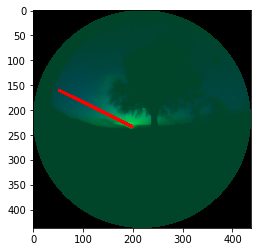

In [12]:
#show line
temp=img_real2view(img_sunrises[0])
lineeg=cv2.line(temp,(198,233),(53,161),(0,0,255),5)
plt.imshow(lineeg[...,::-1])

In [13]:
#one example
point1=(198,233)
point2=(53,161)
temp=createLineIterator(point1, point2, img_sunrises[0,...,0])
print (temp.shape)

#intensity profile
point1s=[[198,233],[198,233],[201,222]]
point2s=[[53,161],[53,161],[56,150]]
intenpro=np.zeros((3,2,145),np.uint8)#3 time points, 2 color channel (UV and G),135 pixels
for ii in range(3):
    for jj in range(2):
        intenpro[ii,jj]=createLineIterator(point1s[ii], point2s[ii], img_sunrises[ii*2,...,jj])[:,2]
intenpro=intenpro/255.0

(145, 3)


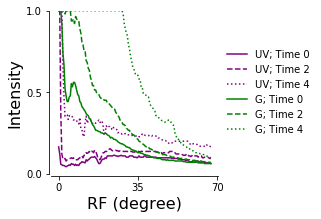

In [15]:
#plot intensity profile in 3 time points
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
ax.plot(intenpro[0,0],color='purple',linestyle='-',label='UV; Time 0')
ax.plot(intenpro[1,0],color='purple',linestyle='--',label='UV; Time 2')
ax.plot(intenpro[2,0],color='purple',linestyle=':',label='UV; Time 4')
ax.plot(intenpro[0,1],color='g',linestyle='-',label='G; Time 0')
ax.plot(intenpro[1,1],color='g',linestyle='--',label='G; Time 2')
ax.plot(intenpro[2,1],color='g',linestyle=':',label='G; Time 4')
ax.legend(loc='best',fontsize=16)
ax.set_xticks([0,75,150])
ax.set_xticklabels(([0,35,70]))
ax.set_ylim([0,1.0])
ax.set_yticks([0,0.5,1.0])
ax.set_xlabel('RF (degree)', fontsize=16)
ax.set_ylabel('Intensity', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))

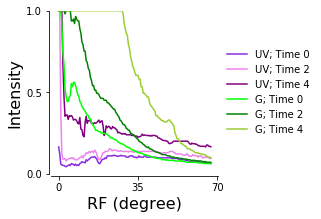

In [16]:
#plot intensity profile in 3 time points
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
ax.plot(intenpro[0,0],color='blueviolet',linestyle='-',label='UV; Time 0')
ax.plot(intenpro[1,0],color='violet',linestyle='-',label='UV; Time 2')
ax.plot(intenpro[2,0],color='purple',linestyle='-',label='UV; Time 4')
ax.plot(intenpro[0,1],color='lime',linestyle='-',label='G; Time 0')
ax.plot(intenpro[1,1],color='g',linestyle='-',label='G; Time 2')
ax.plot(intenpro[2,1],color='yellowgreen',linestyle='-',label='G; Time 4')
ax.legend(loc='best',fontsize=16)
ax.set_xticks([0,75,150])
ax.set_xticklabels(([0,35,70]))
ax.set_ylim([0,1.0])
ax.set_yticks([0,0.5,1.0])
ax.set_xlabel('RF (degree)', fontsize=16)
ax.set_ylabel('Intensity', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))

### Sunrise: Dome and tree intensity change along time points

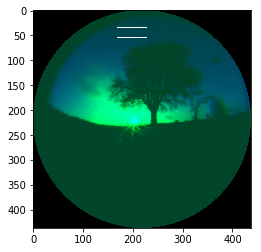

In [17]:
temp=img_real2view(img_sunrises[5])
recteg=cv2.rectangle(temp,(168,35),(228,55),(255,255,255),1)
plt.imshow(recteg[...,::-1])

In [18]:
#dome intensity
domeinten_median=np.zeros((6,2)) #6 time points, 2 color channel (UV and G)
domeinten_std=np.zeros((6,2))
domeinten_lowq_higq=np.zeros((6,2,2)) #6 time points, 2 color channel (UV and G), low and high quantiles(percentiles)
for ii in range(6):
    for jj in range(2):
        temp=img_sunrises[ii,35:55,168:228,jj]/255
        domeinten_median[ii,jj]=np.median(temp)
        domeinten_std[ii,jj]=np.std(temp)
        low_perc,high_perc=bootstrap('median',temp,num_exp=10000,seed=66)
        domeinten_lowq_higq[ii,jj,0]  = domeinten_median[ii,jj]-low_perc #low
        domeinten_lowq_higq[ii,jj,1]  =-domeinten_median[ii,jj]+high_perc #high
#tree intensity
treeinten_median=np.zeros((6,2))#6 time points, 2 color channel (UV and G)
treeinten_std=np.zeros((6,2))
treeinten_lowq_higq=np.zeros((6,2,2)) #6 time points, 2 color channel (UV and G), low and high quantiles(percentiles)
for ii in range(6):
    for jj in range(2):
        temp=img_sunrises[ii,80:100,230:280,jj]/255
        treeinten_median[ii,jj]=np.median(temp)
        treeinten_std[ii,jj]=np.std(temp)
        low_perc,high_perc=bootstrap('median',temp,num_exp=10000,seed=6666)
        treeinten_lowq_higq[ii,jj,0]  = treeinten_median[ii,jj]-low_perc #low
        treeinten_lowq_higq[ii,jj,1]  =-treeinten_median[ii,jj]+high_perc #high

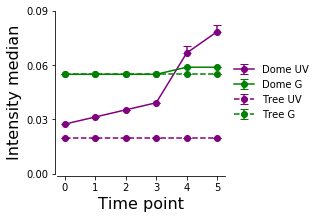

In [19]:
#median, errorbar: 2.5-97.5 percentils
timepoints=[0,1,2,3,4,5]
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
ax.errorbar(timepoints,domeinten_median[:,0],yerr=(domeinten_lowq_higq[:,0,0],domeinten_lowq_higq[:,0,1]),marker='o',\
            color='purple',linestyle='-', label='Dome UV',alpha=1.0, capsize=4)
ax.errorbar(timepoints,domeinten_median[:,1],yerr=(domeinten_lowq_higq[:,1,0],domeinten_lowq_higq[:,1,1]),marker='o',\
            color='g',     linestyle='-', label='Dome G',alpha=1.0, capsize=4)
ax.errorbar(timepoints,treeinten_median[:,0],yerr=(treeinten_lowq_higq[:,0,0],treeinten_lowq_higq[:,0,1]),marker='o',\
            color='purple',linestyle='--',label='Tree UV',alpha=1.0, capsize=4)
ax.errorbar(timepoints,treeinten_median[:,1],yerr=(treeinten_lowq_higq[:,1,0],treeinten_lowq_higq[:,1,1]),marker='o',\
            color='g',     linestyle='--',label='Tree G',alpha=1.0, capsize=4)
ax.legend(loc='best',fontsize=16)
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylim([0,0.09])
ax.set_yticks([0,0.03,0.06,0.09])
ax.set_xlabel('Time point', fontsize=16)
ax.set_ylabel('Intensity median', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))

### Sunrise: Crms change along time points

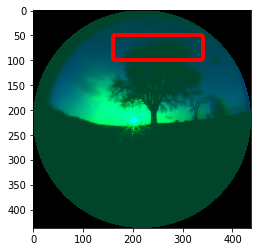

In [20]:
#pick a rectangular area for the tree, not close to the sun, near the edge
temp=img_real2view(img_sunrises[5])
recteg=cv2.rectangle(temp,(160,50),(340,100),(0,0,255),5)
plt.imshow(recteg[...,::-1])

In [23]:
#RF: 2,10 degrees
RFradius=np.array([2,12])
onoff_num=100
#Crms
rms2_time=np.zeros((6,2,2,onoff_num))#6 time points, 2 color channel (UV and G),2 RFs, 100 data
rms2_means=np.zeros((6,2,2))#6 time points, 2 color channel (UV and G),2 RFs
rms2_stds=np.zeros((6,2,2))
rms2_lowq_higq=np.zeros((6,2,2,2)) #the last channel: low and high quantiles(percentiles)
for ii in range(6):
    for jj in range(2):
        for kk in range(2):
            temp=img_sunrises[ii,50:100,160:340,jj]/255
            temprms2s=rms2_random(566+ii*10,onoff_num,RFradius[kk],temp)
            rms2_time[ii,jj,kk]=temprms2s
            rms2_means[ii,jj,kk]=np.mean(temprms2s)
            rms2_stds[ii,jj,kk]=np.std(temprms2s)
            low_perc,high_perc=bootstrap('mean',temprms2s,num_exp=10000,seed=888)
            rms2_lowq_higq[ii,jj,kk,0]  = rms2_means[ii,jj,kk]-low_perc #low
            rms2_lowq_higq[ii,jj,kk,1]  =-rms2_means[ii,jj,kk]+high_perc #high

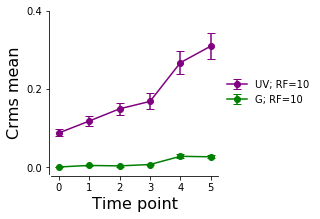

In [26]:
#mean, errorbar: 2.5-97.5 percentiles
timepoints=[0,1,2,3,4,5]
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
ax.errorbar(timepoints,rms2_means[:,0,1],yerr=(rms2_lowq_higq[:,0,1,0],rms2_lowq_higq[:,0,1,1]),marker='o',\
            color='purple',linestyle='-',label='UV; RF=10',alpha=1.0, capsize=4)
ax.errorbar(timepoints,rms2_means[:,1,1],yerr=(rms2_lowq_higq[:,1,1,0],rms2_lowq_higq[:,1,1,1]),marker='o',\
            color='g',     linestyle='-',label='G; RF=10',alpha=1.0, capsize=4)
ax.legend(loc='best',fontsize=16)
ax.set_xticks([0,1,2,3,4,5])
ax.set_yticks([0,0.2,0.4])
ax.set_xlabel('Time point', fontsize=16)
ax.set_ylabel('Crms mean', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))

### Sunset: Conoff and Crms of tree

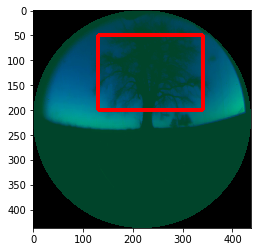

In [38]:
#pick a rectangular area for the tree
temp=img_real2view(img_sunsets[1])
recteg=cv2.rectangle(temp,(130,50),(340,200),(0,0,255),5)
plt.imshow(recteg[...,::-1])

In [39]:
RFradius=np.array([2,7,12,16])
onoff_num=200
#upper visual field, UV channel
upper_UV_RF_rms2s=np.zeros((4,onoff_num))
for ii in range(4):
    temp=img_sunsets[1,50:200,130:340,0]/255
    upper_UV_RF_rms2s[ii]=rms2_random(566+ii*10,onoff_num,RFradius[ii],temp)
#upper visual field, G channel
upper_G_RF_rms2s=np.zeros((4,onoff_num))
for ii in range(4):
    temp=img_sunsets[1,50:200,130:340,1]/255
    upper_G_RF_rms2s[ii]=rms2_random(566+ii*10,onoff_num,RFradius[ii],temp)

In [40]:
#calculate rms2medians
RFradius=np.array([2,7,12,16])
#upper visual field, UV channel
upper_UV_RF_rms2medians=np.zeros(4)
upper_UV_RF_rms2stds=np.zeros(4)
upper_UV_RF_rms2lowqs=np.zeros(4) #lower_quartile
upper_UV_RF_rms2higqs=np.zeros(4) #upper_quartile
for ii in range(4):
    upper_UV_RF_rms2medians[ii]=np.median(upper_UV_RF_rms2s[ii])
    upper_UV_RF_rms2stds[ii]=np.std(upper_UV_RF_rms2s[ii])
    low_perc,high_perc=bootstrap('median',upper_UV_RF_rms2s[ii],num_exp=10000,seed=66)
    upper_UV_RF_rms2lowqs[ii]  = upper_UV_RF_rms2medians[ii]-low_perc
    upper_UV_RF_rms2higqs[ii]  =-upper_UV_RF_rms2medians[ii]+high_perc 
#upper visual field, G channel
upper_G_RF_rms2medians=np.zeros(4)
upper_G_RF_rms2stds=np.zeros(4)
upper_G_RF_rms2lowqs=np.zeros(4) #lower_quartile
upper_G_RF_rms2higqs=np.zeros(4) #upper_quartile
for ii in range(4):
    upper_G_RF_rms2medians[ii]=np.median(upper_G_RF_rms2s[ii])
    upper_G_RF_rms2stds[ii]=np.std(upper_G_RF_rms2s[ii])
    low_perc,high_perc=bootstrap('median',upper_G_RF_rms2s[ii],num_exp=10000,seed=66)
    upper_G_RF_rms2lowqs[ii]  = upper_G_RF_rms2medians[ii]-low_perc
    upper_G_RF_rms2higqs[ii]  =-upper_G_RF_rms2medians[ii]+high_perc 

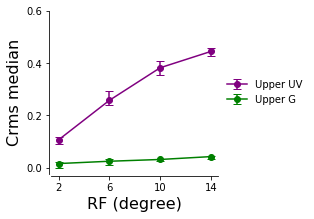

In [41]:
#median, errorbar: 2.5-97.5 percentiles
RFs=np.array([2,6,10,14])
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
ax.errorbar(RFs,upper_UV_RF_rms2medians,yerr=(upper_UV_RF_rms2lowqs,upper_UV_RF_rms2higqs),marker='o',\
            color='purple',linestyle='-',label='Upper UV',alpha=1.0, capsize=4)
ax.errorbar(RFs,upper_G_RF_rms2medians, yerr=(upper_G_RF_rms2lowqs,upper_G_RF_rms2higqs),  marker='o',\
            color='g',     linestyle='-',label='Upper G', alpha=1.0, capsize=4)
ax.legend(loc='best',fontsize=16)
ax.set_xticks([2,6,10,14])
ax.set_yticks([0,0.2,0.4,0.6])
ax.set_xlabel('RF (degree)', fontsize=16)
ax.set_ylabel('Crms median', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))